In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# %pip install keras-tuner --upgrade
import keras_tuner
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from common_functions import *


def plot_loss(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title("Loss")
    plt.legend()
    plt.show()


def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[(i+look_back), 0])
    return np.array(X), np.array(Y)


def build_model(hp, train_shape, look_back):
    model = Sequential()
    #  if hp is passed then tune hyperparameters
    if hp:
        # todo try bidirectional lstm layers instead of normal lstm layers
        # model.add(Bidirectional(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(train_shape, look_back))))
        model.add(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=366, step=32), return_sequences=True, input_shape=(train_shape, look_back)))
        # model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.3, step=0.1)))
        # model.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=366, step=32), return_sequences=True))
        # model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.3, step=0.1)))
        # model.add(LSTM(units=hp.Int('lstm_units_3', min_value=32, max_value=366, step=32), return_sequences=True))
        # model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.3, step=0.1)))
        model.add(Dense(1))
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=hp_learning_rate), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    else:
        # +validation
        # 1
        # model.add(LSTM(units=50, return_sequences=True, input_shape=(train_shape, look_back)))
        # 2
        model.add(LSTM(units=100, return_sequences=True, input_shape=(train_shape, look_back)))
        # 3
        # model.add(LSTM(units=100, return_sequences=True, input_shape=(train_shape, look_back)))
        # model.add(Dropout(rate=0.1))
        # 4
        # model.add(LSTM(units=50, return_sequences=True, input_shape=(train_shape, look_back)))
        # model.add(LSTM(units=100, return_sequences=True))
        # 5
        # model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(train_shape, look_back))))
        # 6
        # model.add(LSTM(units=360, return_sequences=True, input_shape=(train_shape, look_back)))
        # model.add(LSTM(units=180, return_sequences=True))
        # model.add(LSTM(units=60, return_sequences=True))
        # 7
        # model.add(LSTM(units=365, return_sequences=True, input_shape=(train_shape, look_back)))
        # model.add(Dense(64))

        # model.add(Bidirectional(LSTM(units=512, return_sequences=True, input_shape=(train_shape, look_back))))
        # model.add(Dropout(rate=0.2))
        # model.add(Bidirectional(LSTM(units=512, return_sequences=True)))

        model.add(Dense(1))
        initial_learning_rate = 0.1
        lr_schedule = ExponentialDecay(
            initial_learning_rate,
            decay_steps=100,
            decay_rate=0.5,
            staircase=True)
        model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

# Maybe load_data(filename, input_dir, label, start_date, end_date, slice_date)
def load_data(filename,  input_dir, label, number_of_test_values):
    # Load the CSV file
    df = pd.read_csv(os.path.join(input_dir,filename))
    df.DateTime = pd.to_datetime(df.DateTime)

    date = df['DateTime'].max() - pd.Timedelta(days=number_of_test_values-1)
    train_data, test_data = train_test_split_by_date(df, date)

    # plot_train_test_data(train_data, test_data, 'DateTime', label)

    start_date, slice_date, end_date = train_data.DateTime.min(), train_data.DateTime.max(), test_data.DateTime.max()

    train_data = train_data.set_index('DateTime')
    test_data = test_data.set_index('DateTime')

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)

    return train_data, test_data, scaler, start_date, slice_date, end_date

def train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters):
    # Prepare input and output for LSTM model
    x_train, y_train = create_dataset(train_data, look_back)

    # reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

    # Splitting the last val_size of data for validation
    val_size = int(0.1 * len(x_train))
    x_train, y_train = x_train[:-val_size], y_train[:-val_size]
    x_val, y_val = x_train[-val_size:], y_train[-val_size:]

    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    if tune_hyperparameters:
        # Training the model
        tuner = keras_tuner.Hyperband(
                            # must be wrapped in lambda because build_model() takes more than hp as argument
                            hypermodel=lambda hp: build_model(hp, x_train.shape[1], look_back),
                            objective=[keras_tuner.Objective("val_loss", "min")],
                            max_epochs=10,
                            overwrite=True,
                            project_name='LSTM_hyperparameter_tuning'
                            )
        tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop])
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        print("\nBest hyperparameters: \n")
        print(best_hps.values)

        model = tuner.hypermodel.build(best_hps)
    else:
        model = build_model(hp=None, train_shape=x_train.shape[1], look_back=look_back)
        
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stop])
    plot_loss(history)
    
    return model, history

def test_LSTM_model(model, train_data, test_data, look_back, scaler):
    # Testing the model using sequential predictions
    # making test set: x_test[0] = x_train[-5:]; x_test[1] = x_train[-4:],x_test[0]; x_test[2] = x_train[-3:],x_test[0],x_test[1] and so on
    x_test = train_data[-look_back:]
    y_test = test_data
    testPredict = []

    for i in range(0, len(test_data)):
        x_test, y_test = np.array(x_test), np.array(y_test)
        x_test = np.reshape(x_test, (1, 1, look_back))
        y_pred = model.predict(x_test)
        # append y_pred value to testPredict
        testPredict.append(y_pred[0][0])
        # push the predictions to the end of the test set so it pushes out first value 
        x_test = np.append(x_test, y_pred)
        x_test = x_test[1:]


    testPredict = scaler.inverse_transform(testPredict)
    y_test = scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test, testPredict)
    rmse = np.sqrt(mean_squared_error(y_test, testPredict))
    r2 = r2_score(y_test, testPredict)
    smape = calculate_smape(y_test, testPredict)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2 Score:", r2)
    print("SMAPE:", smape)

    # plot y_test and testPredict
    plt.plot(y_test, label='Actual value', color='blue')
    plt.plot(testPredict, label='Test Prediction', color='orange')
    plt.legend()
    plt.show()

    plot_boxplot(testPredict, y_test)

    return rmse, mae, r2, smape, testPredict, y_test


Running experiment for dataset_aqi_daily.csv with label AQI:

Epoch 1/10
101/101 [==============================] - 2s 9ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - mean_absolute_error: 0.0845 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.0459
Epoch 2/10
101/101 [==============================] - 1s 6ms/step - loss: 0.0138 - root_mean_squared_error: 0.1177 - mean_absolute_error: 0.0808 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.0538
Epoch 3/10
101/101 [==============================] - 1s 6ms/step - loss: 0.0137 - root_mean_squared_error: 0.1172 - mean_absolute_error: 0.0815 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.0480
Epoch 3: early stopping


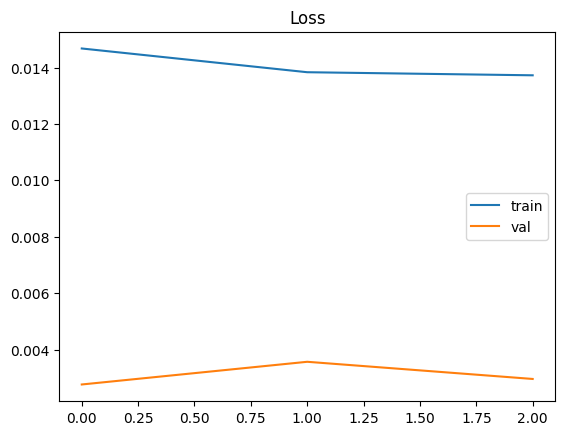

1/1 [==============================] - 0s 21ms/step
RMSE: 32.2597346201189
MAE: 29.848132461346687
R2 Score: -2.398106329955566
SMAPE: 49.083737170774775


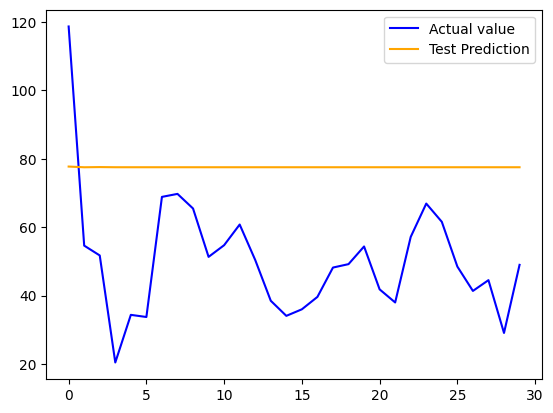

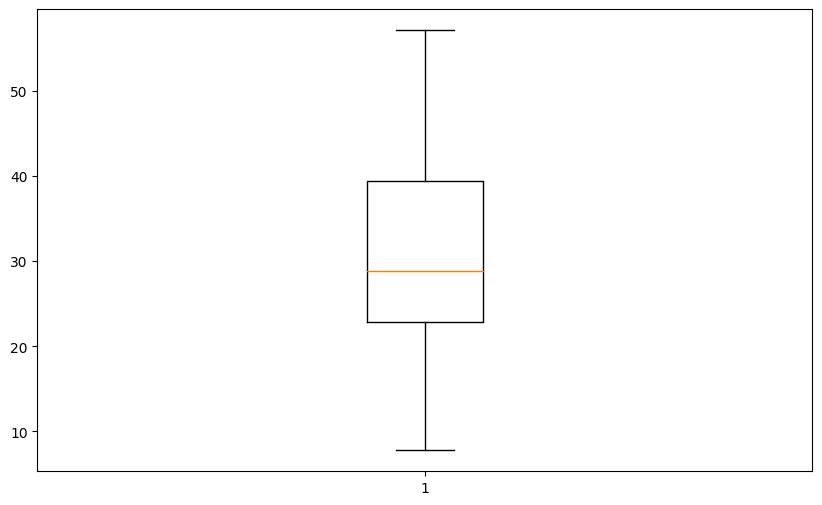

C:\Users\Vahidin\AppData\Local\Temp\ipykernel_8448\3042150309.py:50: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  'DateTime of experiment': [pd.datetime.now()],


In [27]:
# Write experiment data to file
dir_name = 'Results'
file_name = 'LSTM_experiment_results.csv'
file_path = os.path.join(dir_name, file_name)

# Create the directory if it doesn't exist
os.makedirs(dir_name, exist_ok=True)


# one day, one week, two weeks, 1 month, 2 months, 6 months
# test_sizes_daily = [1, 1*7, 2*7, 4*7, 8*7, 24*7]
# test_sizes_daily = [30]

# Experiment parameters
# todo push code to github
# todo trenirati sa validacijom 
# todo za dana uzeti 3 a za sate 5 ili 10
look_back = 3
# za dane 32 za sate 128
batch_size, epochs = 16, 10
tune_hyperparameters = False

# experiment_cases = [
#     {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'test_sizes': [1, 1*7, 2*7, 4*7, 8*7, 24*7]}, 
#     {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly.csv", 'label': "AQI", 'test_sizes': [1, 1*7, 2*7, 4*7]},
#     {'input_dir': "Dataset", 'filename': "dataset_aqi_daily_filled_with_neighbors.csv", 'label': "AQI", 'test_sizes': [1, 1*7, 2*7, 4*7, 8*7, 24*7]}, 
#     {'input_dir': "Dataset", 'filename': "dataset_aqi_hourly_filled_with_neighbors.csv", 'label': "AQI", 'test_sizes': [1, 1*7, 2*7, 4*7]}
# ]

experiment_cases = [
    {'input_dir': "Dataset", 'filename': "dataset_aqi_daily.csv", 'label': "AQI", 'test_sizes': [30]}
]

for experiment_case in experiment_cases:
    input_dir = experiment_case['input_dir']
    filename = experiment_case['filename']
    label = experiment_case['label']
    test_sizes = experiment_case['test_sizes']
    # Rest of your code
    print(f'\nRunning experiment for {filename} with label {label}:\n')
    for test_size in test_sizes:
        train_data, test_data, scaler, start_date, slice_date, end_date = load_data(filename, input_dir, label, test_size)

        model, history = train_LSTM_model(train_data, look_back, batch_size, epochs, tune_hyperparameters)

        rmse, mae, r2, smape, testPredict, y_test = test_LSTM_model(model, train_data, test_data, look_back, scaler)

        # Prepare data for CSV
        data = {
            'DateTime of experiment': [pd.datetime.now()],
            'Dataset used': [filename],
            'Label predicted': [label],
            'Training data from': [start_date],
            'Training data to': [slice_date],
            'Testing data from': [slice_date],
            'Testing data to': [end_date],
            'Test size': [len(test_data)],
            'look_back': [look_back],
            'batch_size': [batch_size],
            'epochs': [epochs],
            'Model configuration': [json.dumps(model.get_config())],
            'Test Predictions': [testPredict.tolist()],
            'Test Data': [y_test.tolist()],
            'RMSE': [rmse],
            'MAE': [mae],
            'R2': [r2],
            'SMAPE': [smape]
        }

        # Convert to DataFrame
        df = pd.DataFrame(data)

        # Write DataFrame to CSV
        df.to_csv(file_path, mode='a', header=not os.path.exists(file_path), index=False)